In [182]:
%load_ext autoreload
%autoreload 2

In [183]:
import numpy as np
from xmitgcm import open_mdsdataset
from xhistogram.xarray import histogram

from osse import *
from canyon_utils import *
from sloped_MITgcm import *

In [184]:
Γ = 0.0008613659531090722
N = np.sqrt(g*α*Γ)
θ = 1.26E-3
f = 5.3e-5

h = 230
k0 = 5.2e-5
k1 = 1.8e-3

dx = 600.
delta_t = 15.

In [598]:
ds_dict = {}
db_dict = {}

add_dep = {"-plane": 800., "-canyon-lowres": 127.5, "-canyon": 0., "-canyon-2D":0.}

for exp in ["-plane", "-canyon", "-canyon-2D", "-sill"]:
    data_dir = f"../../MITgcm/experiments/rotated_BBTRE_idealized{exp}/run_spinup/"
    ds = open_mdsdataset(data_dir,ignore_unknown_vars=True,prefix=["standardDiag"], delta_t=delta_t)
    db = open_mdsdataset(data_dir,iters=[144000, 432000, 7056000], ignore_unknown_vars=True,prefix=["budgetDiag"], delta_t=delta_t)
    ds, grid = add_rotated_coords(ds, θ)
    db, gridb = add_rotated_coords(db, θ)
    
    ds["ζx"] = (
         grid.interp(grid.interp(grid.diff(ds["VVEL"], "Z", boundary="fill", fill_value=np.nan), axis="Z", boundary="fill", fill_value=np.nan), axis="Y")/ds["drF"]
        +grid.interp(grid.interp(grid.diff(ds["WVEL"], "Y")/ds["dyC"], axis="Y"), axis="Z", boundary="fill", fill_value=np.nan)
    )
    
    db = add_hab_coordinates(db, gridb, vert_coord='Zl', gridface='C')
    db['wb'] = db['ADVr_TH']/db["rA"]
    db['wb_hab'] = hab_interp(db['wb'], vert_coord='Zl')
    db['wb_hab_av'] = db['wb_hab'].mean(['XC', 'YC'], skipna=True).compute()
    
    geo = xr.open_dataset(data_dir+"geocoords.nc")
    ds['Depth_actual'] = xr.zeros_like(ds['Depth']) - geo['z_actual'].values

    ds = add_background_temp(ds, Γ)
    ds['Nsq'] = -g/ρ0*ds['DRHODR'].where(ds['DRHODR']!=0.)+g*α*Γ
    
    ds.attrs["dx"] = 600.; ds.attrs["dy"] = 600.;
    ds.attrs["Ly"] = ds.YC.size*ds.attrs["dy"]
    ds.attrs["Lx"] = ds.XC.size*ds.attrs["dx"]
    
    if exp=="-plane":
        ds=ds.assign_coords({'Z':ds["Z"]+add_dep[exp], 'Zl':ds["Zl"]+add_dep[exp], 'Zp1':ds["Zp1"]+add_dep[exp]})
        db=db.assign_coords({'Z':db["Z"]+add_dep[exp], 'Zl':db["Zl"]+add_dep[exp], 'Zp1':db["Zp1"]+add_dep[exp]})
    
    ds_dict[exp] = ds
    db_dict[exp] = db

/nobackup1b/users/hdrake/bblturb/notebooks/BBTRE_physics_analysis/sloped_MITgcm.py:64: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  da_itp = xr.apply_ufunc(
/nobackup1b/users/hdrake/bblturb/notebooks/BBTRE_physics_analysis/sloped_MITgcm.py:64: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  da_itp = xr.apply_ufunc(
/nobackup1b/users/hdrake/bblturb/notebooks/BBTRE_physics_analysis/sloped_MITgcm.py:64: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  da_itp = xr.apply_ufunc(


OSError: Could not find the expected file prefixes ['budgetDiag'] at iternum 7.056e+06. (Instead found [])

In [554]:
k_lev = [70]
data_dir = f"../../MITgcm/experiments/rotated_BBTRE_idealized-canyon-lowres/run/"

ds = open_mdsdataset(data_dir,ignore_unknown_vars=True,prefix=["standardDiag"], delta_t=delta_t)
ds, grid = add_rotated_coords(ds, θ)

snap = open_mdsdataset(data_dir, ignore_unknown_vars=True, levels=k_lev, prefix=["levelDiag"], delta_t=delta_t, read_grid=False)
snap = snap.isel(time=-1)
snap = snap.rename_dims({
    "i": "XC", "i_g": "XG",
    "j": "YC", "j_g": "YG",
    "k": "Z", "k_u": "Zu", "k_l": "Zl", "k_p1": "Zp1"
})
snap = snap.assign_coords(ds.isel(Z=k_lev, Zp1=np.append(k_lev, k_lev[-1]+1), Zu=k_lev, Zl=k_lev).coords)

In [560]:
ds['Nsq'] = -g/ρ0*ds['DRHODR'].where(ds['DRHODR']!=0.)+g*α*Γ

In [555]:
ζ = grid.interp(grid.interp((-grid.diff(snap.UVEL * snap.dxC, 'Y')
     +grid.diff(snap.VVEL * snap.dyC, 'X'))/snap.rAz,
'X'), 'Y')
ζ.name = 'relative vorticity'
ζ = ζ.where(snap.hFacC != 0.)

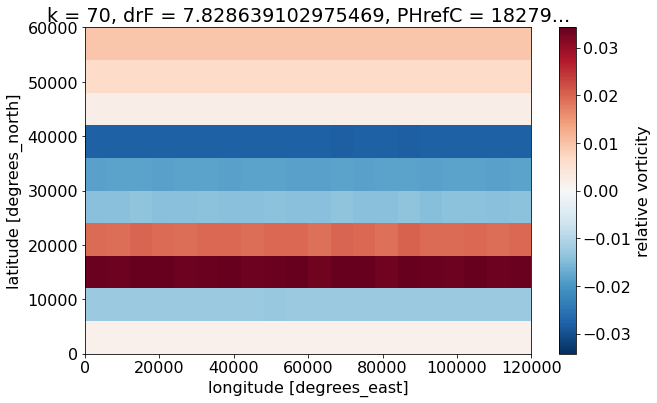

In [556]:
(ζ/f).plot()

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.9/site-packages/xarray/plot/plot.py:932: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hdrake/.conda/envs/bblturb-analysis/lib/py

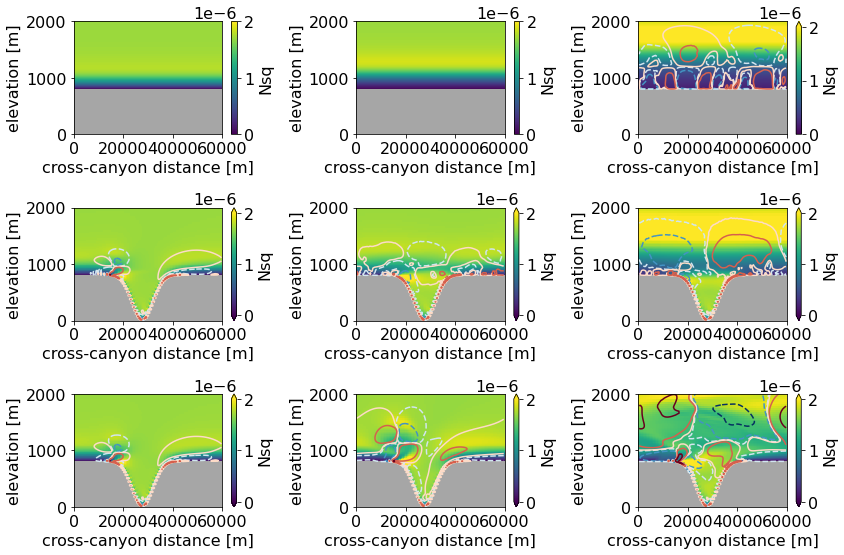

In [570]:
levels = [-5e-6, -5.e-7, -5.e-8, 5.e-8, 5.e-7, 5.e-6]

plt.figure(figsize=(12, 8))
for ti, t in enumerate([0,1,-1]):
    for i, (k, v) in enumerate(ds_dict.items()):
        ax = plt.subplot(len(ds_dict),3,i*3+ti+1, facecolor=nancol)
        v['Nsq'].mean(['XC']).isel(time=t).plot(ax=ax, cmap=cmap, vmin=0., vmax=2e-6)
        cntr = (db_dict[k]['ADVr_TH']/db_dict[k]["rA"]).mean(['XC']).isel(time=ti).plot.contour(
            ax=ax, cmap=div_cmap, levels=levels, alpha=1.)
        cntr.monochrome = True
        for col, ls in zip(cntr.collections, cntr._process_linestyles()):
            col.set_linestyle(ls)
        plt.title("")
        plt.ylim(0, 2000)
        plt.xlabel("cross-canyon distance [m]")
        plt.ylabel("elevation [m]")
plt.tight_layout()

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.9/site-packages/matplotlib/contour.py:1430: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.9/site-packages/matplotlib/contour.py:1431: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.9/site-packages/xarray/plot/plot.py:932: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hdrake/.conda/envs/bblturb-analysis/lib/python

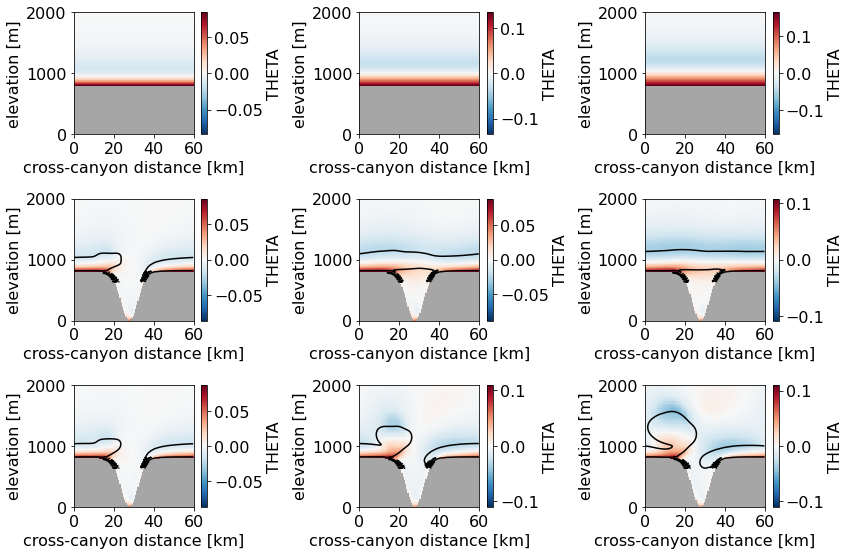

In [493]:
levels = [-1.e-2, 1e-2]

plt.figure(figsize=(12, 8))
for ti, t in enumerate([0,1,-1]):
    for i, (k, v) in enumerate(ds_dict.items()):
        ax = plt.subplot(len(ds_dict),3,i*3+ti+1, facecolor=nancol)
        ds_dict[k]['THETA'].mean(['XC']).isel(time=ti).plot(
            ax=ax, cmap=div_cmap)
        v["ζ"].where(v["Z"]>625.).isel(time=ti).mean('XC').plot.contour(vmin=-1e-4, vmax=1e-4, colors="k", levels=[2e-6, np.nan])
        plt.title("")
        plt.ylim(0, 2000)
        plt.xlabel("cross-canyon distance [km]")
        xt = np.array([0, 20, 40, 60])
        plt.xticks(xt*1e3, xt)
        plt.ylabel("elevation [m]")
plt.tight_layout()

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.9/site-packages/matplotlib/contour.py:1430: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.9/site-packages/matplotlib/contour.py:1431: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.9/site-packages/xarray/plot/plot.py:932: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)
/home/hdrake/.conda/envs/bblturb-analysis/lib/python

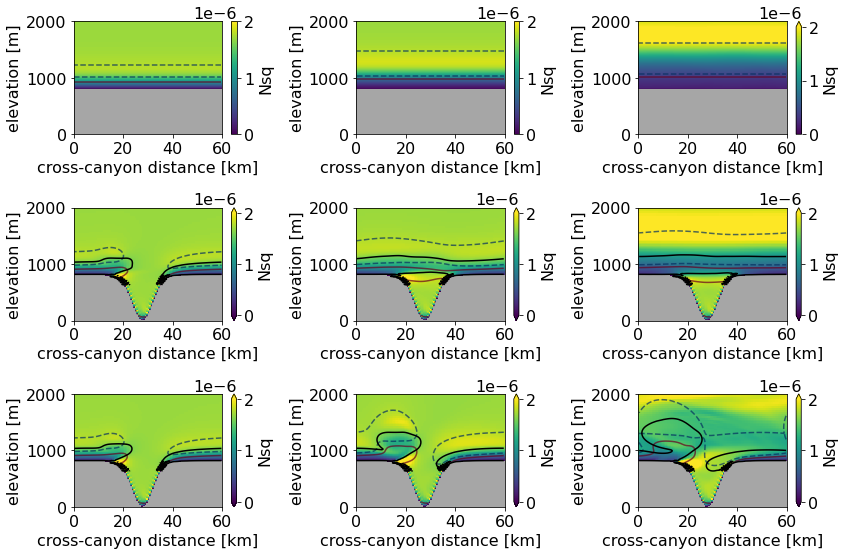

In [458]:
levels = [-1.e-2, 1e-2]

plt.figure(figsize=(12, 8))
for ti, t in enumerate([0,1,-1]):
    for i, (k, v) in enumerate(ds_dict.items()):
        ax = plt.subplot(len(ds_dict),3,i*3+ti+1, facecolor=nancol)
        v['Nsq'].mean(['XC']).isel(time=t).plot(ax=ax, cmap=cmap, vmin=0., vmax=2e-6)
        (ds_dict[k]['THETA']).mean(['XC']).isel(time=ti).plot.contour(
            ax=ax, cmap=div_cmap, levels=levels, alpha=0.7)
        v["ζ"].where(v["Z"]>625.).isel(time=ti).mean('XC').plot.contour(vmin=-1e-4, vmax=1e-4, colors="k", levels=[2e-6, np.nan])
        plt.title("")
        plt.ylim(0, 2000)
        plt.xlabel("cross-canyon distance [km]")
        xt = np.array([0, 20, 40, 60])
        plt.xticks(xt*1e3, xt)
        plt.ylabel("elevation [m]")
plt.tight_layout()

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.9/site-pack

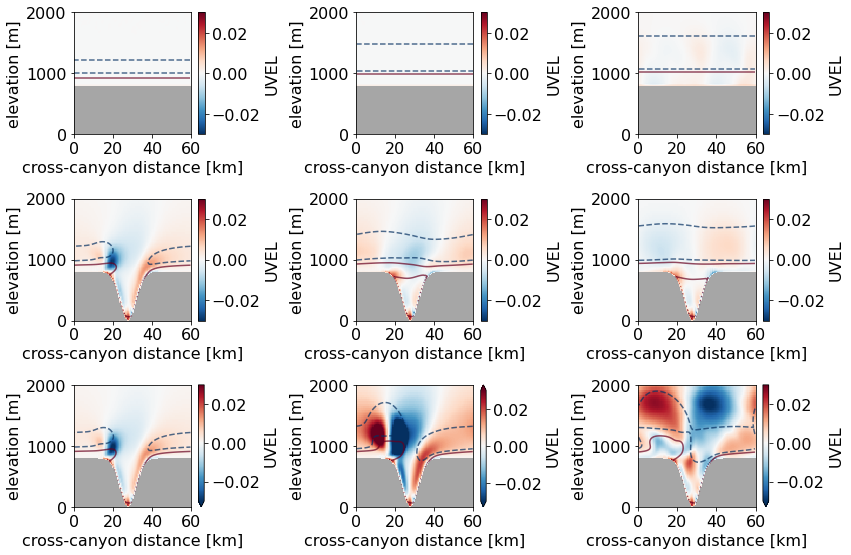

In [465]:
plt.figure(figsize=(12, 8))
for ti, t in enumerate([0,1,-1]):
    for i, (k, v) in enumerate(ds_dict.items()):
        ax = plt.subplot(len(ds_dict),3,i*3+ti+1, facecolor=nancol)
        v['UVEL'].where(v["UVEL"]!=0.).mean(['XG']).isel(time=t).plot(ax=ax, cmap=div_cmap, vmin=-3.e-2, vmax=3e-2)
        (ds_dict[k]['THETA']).mean(['XC']).isel(time=ti).plot.contour(
            ax=ax, cmap=div_cmap, levels=levels, alpha=0.7)
        plt.title("")
        plt.ylim(0, 2000)
        plt.xlabel("cross-canyon distance [km]")
        xt = np.array([0, 20, 40, 60])
        plt.xticks(xt*1e3, xt)
        plt.ylabel("elevation [m]")
plt.tight_layout()

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.9/site-pack

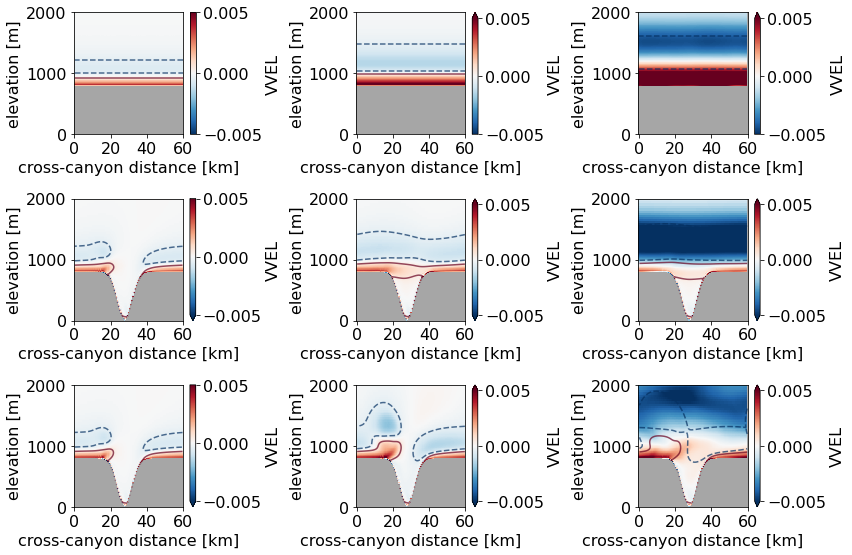

In [492]:
plt.figure(figsize=(12, 8))
for ti, t in enumerate([0,1,-1]):
    for i, (k, v) in enumerate(ds_dict.items()):
        ax = plt.subplot(len(ds_dict),3,i*3+ti+1, facecolor=nancol)
        v['VVEL'].where(v["VVEL"]!=0.).mean(['XC']).isel(time=t).plot(ax=ax, cmap=div_cmap, vmin=-5.e-3, vmax=5e-3)
        (ds_dict[k]['THETA']).mean(['XC']).isel(time=ti).plot.contour(
            ax=ax, cmap=div_cmap, levels=levels, alpha=0.7)
        plt.title("")
        plt.ylim(0, 2000)
        plt.xlabel("cross-canyon distance [km]")
        xt = np.array([0, 20, 40, 60])
        plt.xticks(xt*1e3, xt)
        plt.ylabel("elevation [m]")
plt.tight_layout()

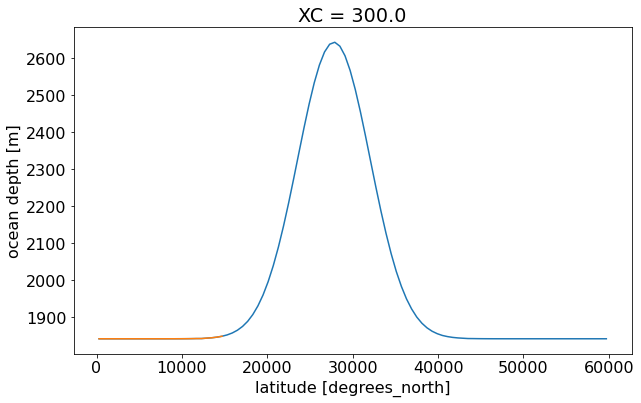

In [303]:
ds["Depth"].isel(YC=slice(0, 100)).plot()
ds["Depth"].isel(YC=slice(0, 25)).plot()

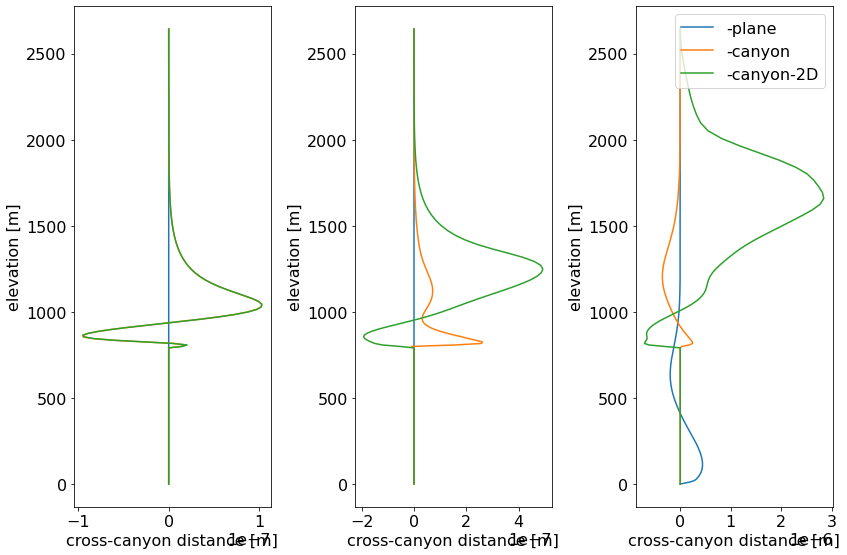

In [316]:
levels = [-5e-6, -5.e-7, -5.e-8, 5.e-8, 5.e-7, 5.e-6]
Yslice = np.append(np.arange(0, 25, 1), np.arange(75, 100, 1))

plt.figure(figsize=(12, 8))
for ti, t in enumerate([0,1,-1]):
    for i, (k, v) in enumerate(ds_dict.items()):
        ax = plt.subplot(1,3,ti+1)
        (db_dict[k]['ADVr_TH']/db_dict[k]["rA"]).mean(['XC']).isel(YC=Yslice).mean("YC").isel(time=ti).plot(
            ax=ax, y="Zl", label=k)
        plt.title("")
        plt.xlabel("cross-canyon distance [m]")
        plt.ylabel("elevation [m]")
plt.tight_layout()
plt.legend()

In [277]:
db_dict[k]['ADVr_TH'].mean(['XC']).isel(time=ti).plot.contour(ax=ax, cmap=div_cmap, vmin=-5e-1, vmax=5e-1)

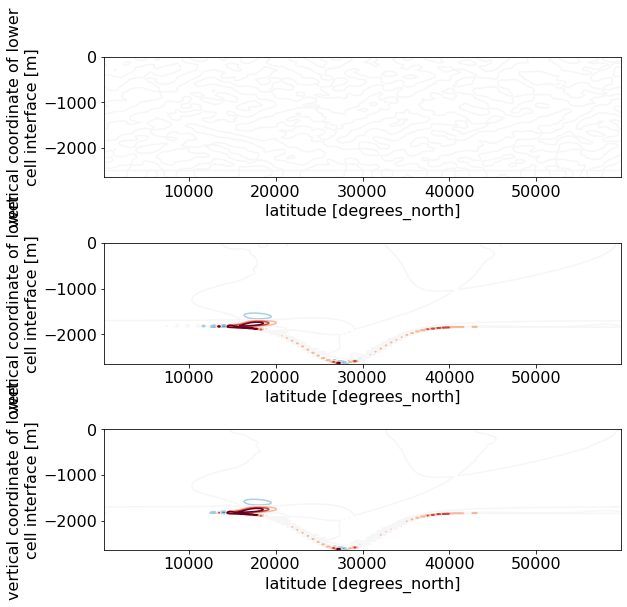

In [271]:
ti = 0

plt.figure(figsize=(9, 8))
for i, (k, v) in enumerate(db_dict.items()):
    plt.subplot(len(ds_dict),1,i+1)
    
    plt.title("")
plt.tight_layout()

In [244]:
data_dir = f"../../MITgcm/experiments/rotated_BBTRE_idealized-canyon/run_spinup/"
db = open_mdsdataset(data_dir, iters=list(np.arange(144000, 144000*27, 144000*2)), ignore_unknown_vars=True, prefix=["budgetDiag"], delta_t=delta_t)

OSError: Could not find the expected file prefixes ['budgetDiag'] at iternum 3.6e+06. (Instead found [])

14400

In [249]:
np.append(np.arange(144000, 144000*27, 144000*2), np.arange(367200, 144000*50, 14400*2))

array([ 144000,  432000,  720000, 1008000, 1296000, 1584000, 1872000,
       2160000, 2448000, 2736000, 3024000, 3312000, 3600000,  367200,
        396000,  424800,  453600,  482400,  511200,  540000,  568800,
        597600,  626400,  655200,  684000,  712800,  741600,  770400,
        799200,  828000,  856800,  885600,  914400,  943200,  972000,
       1000800, 1029600, 1058400, 1087200, 1116000, 1144800, 1173600,
       1202400, 1231200, 1260000, 1288800, 1317600, 1346400, 1375200,
       1404000, 1432800, 1461600, 1490400, 1519200, 1548000, 1576800,
       1605600, 1634400, 1663200, 1692000, 1720800, 1749600, 1778400,
       1807200, 1836000, 1864800, 1893600, 1922400, 1951200, 1980000,
       2008800, 2037600, 2066400, 2095200, 2124000, 2152800, 2181600,
       2210400, 2239200, 2268000, 2296800, 2325600, 2354400, 2383200,
       2412000, 2440800, 2469600, 2498400, 2527200, 2556000, 2584800,
       2613600, 2642400, 2671200, 2700000, 2728800, 2757600, 2786400,
       2815200, 2844

In [251]:
7192800+7200

7200000

In [205]:
db.data_vars

Data variables:
    THETA     (time, Z, YC, XC) float64 dask.array<chunksize=(1, 200, 100, 1), meta=np.ndarray>
    ADVr_TH   (time, Zl, YC, XC) float64 dask.array<chunksize=(1, 200, 100, 1), meta=np.ndarray>
    ADVx_TH   (time, Z, YC, XG) float64 dask.array<chunksize=(1, 200, 100, 1), meta=np.ndarray>
    ADVy_TH   (time, Z, YG, XC) float64 dask.array<chunksize=(1, 200, 100, 1), meta=np.ndarray>
    DFrI_TH   (time, Zl, YC, XC) float64 dask.array<chunksize=(1, 200, 100, 1), meta=np.ndarray>
    DFxE_TH   (time, Z, YC, XG) float64 dask.array<chunksize=(1, 200, 100, 1), meta=np.ndarray>
    DFyE_TH   (time, Z, YG, XC) float64 dask.array<chunksize=(1, 200, 100, 1), meta=np.ndarray>
    WVEL      (time, Zl, YC, XC) float64 dask.array<chunksize=(1, 200, 100, 1), meta=np.ndarray>
    UVEL      (time, Z, YC, XG) float64 dask.array<chunksize=(1, 200, 100, 1), meta=np.ndarray>
    VVEL      (time, Z, YG, XC) float64 dask.array<chunksize=(1, 200, 100, 1), meta=np.ndarray>
    TOTTTEND  (time, 

In [ ]:
ti = 1

plt.figure(figsize=(9, 8))
for i, (k, v) in enumerate(ds_dict.items()):
    plt.subplot(len(ds_dict),1,i+1)
    v[''].mean(['XC']).isel(time=ti).plot(cmap=cmap, vmin=0., vmax=2e-6)
    plt.title("")
plt.tight_layout()

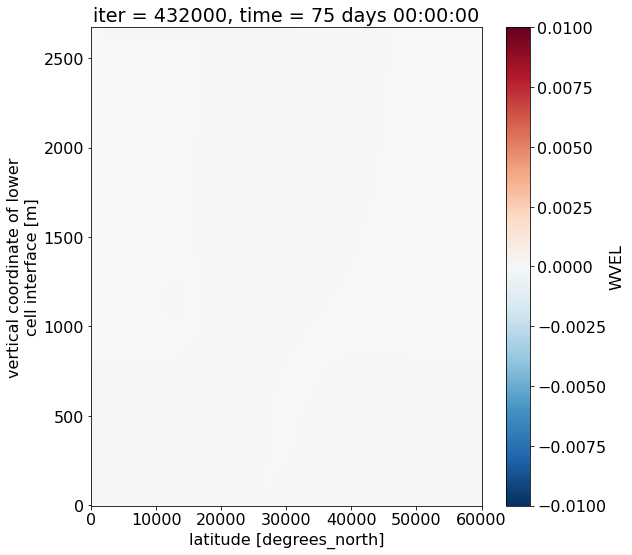

In [179]:
plt.figure(figsize=(9, 8))
for i, (k, v) in enumerate(ds_dict.items()):
    plt.subplot(len(ds_dict),1,i+1)
    v['WVEL'].mean(['XC']).isel(time=1).plot(cmap=div_cmap, vmin=-1e-2, vmax=1e-2)
plt.tight_layout()

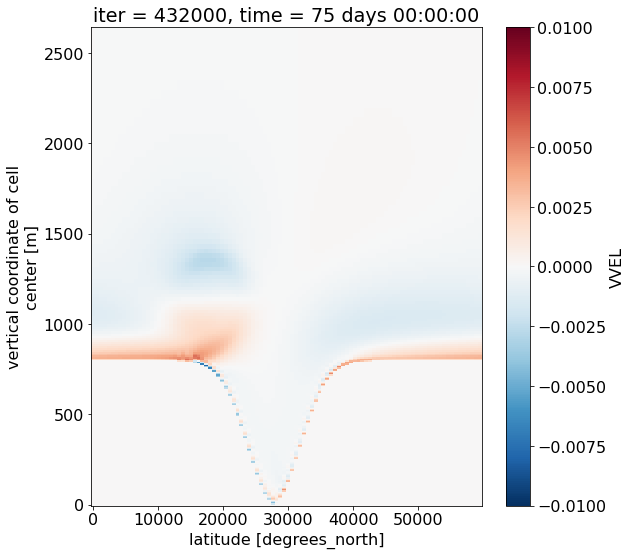

In [175]:
plt.figure(figsize=(9, 8))
for i, (k, v) in enumerate(ds_dict.items()):
    plt.subplot(len(ds_dict),1,i+1)
    v['VVEL'].mean(['XC']).isel(time=1).plot(cmap=div_cmap, vmin=-1e-2, vmax=1e-2)
plt.tight_layout()

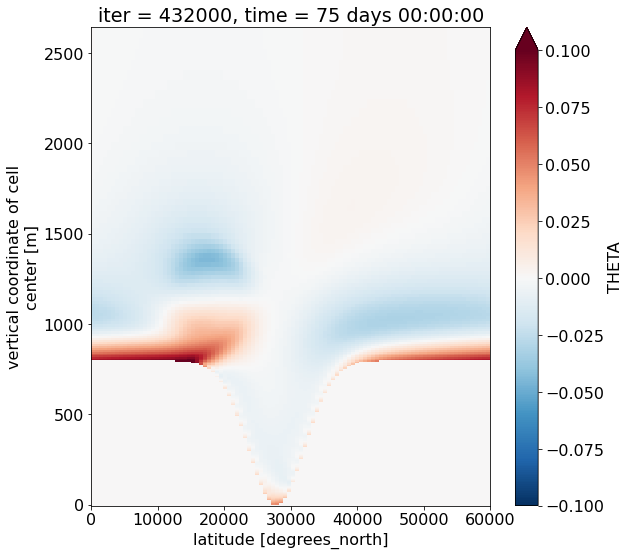

In [164]:
plt.figure(figsize=(9, 8))
for i, (k, v) in enumerate(ds_dict.items()):
    plt.subplot(len(ds_dict),1,i+1)
    v['THETA'].mean(['XC']).isel(time=1).plot(cmap=div_cmap, vmin=-1e-1, vmax=1e-1)
plt.tight_layout()

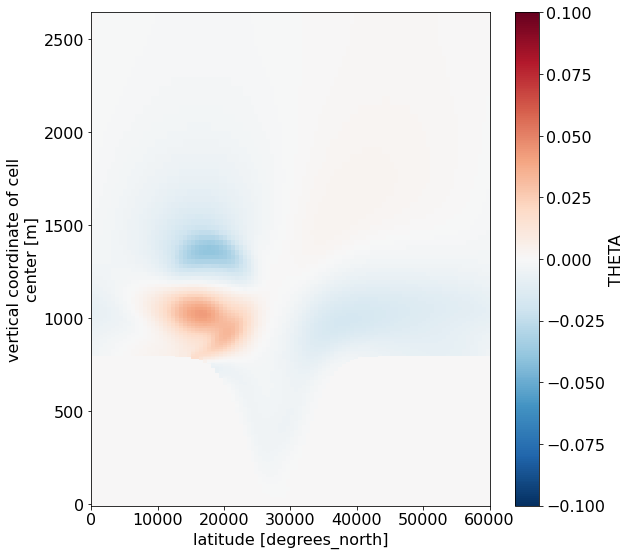

In [173]:
plt.figure(figsize=(9, 8))
for i, (k, v) in enumerate(ds_dict.items()):
    plt.subplot(len(ds_dict),1,i+1)
    (v['THETA'].mean(['XC']).isel(time=1)-v['THETA'].mean(['XC']).isel(time=0)).plot(cmap=div_cmap, vmin=-1e-1, vmax=1e-1)
plt.tight_layout()

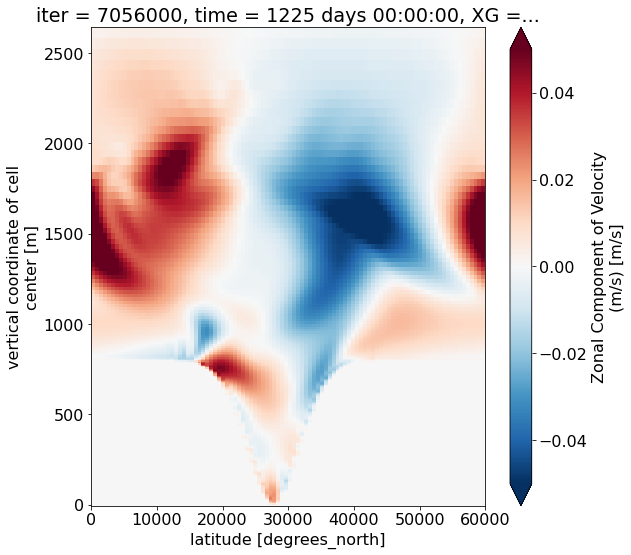

In [134]:
plt.figure(figsize=(9, 8))
for i, (k, v) in enumerate(ds_dict.items()):
    plt.subplot(len(ds_dict),1,i+1)
    v['UVEL'].isel(time=-1).plot(cmap=div_cmap, vmin=-5e-2, vmax=5e-2)
plt.tight_layout()

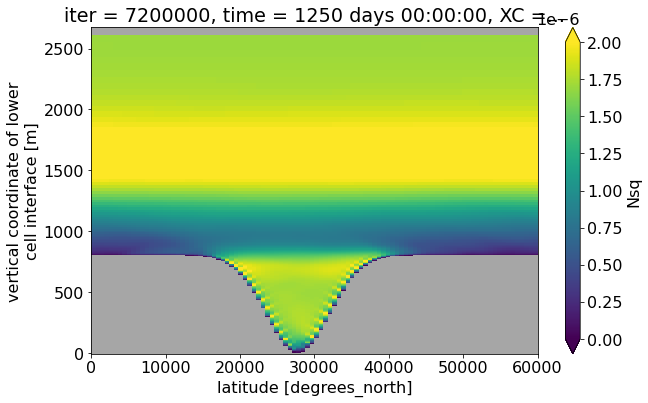

In [62]:
ds_dict["-canyon"]['Nsq'].isel(XC=50, time=-1).plot(cmap=cmap, vmin=0., vmax=2e-6)

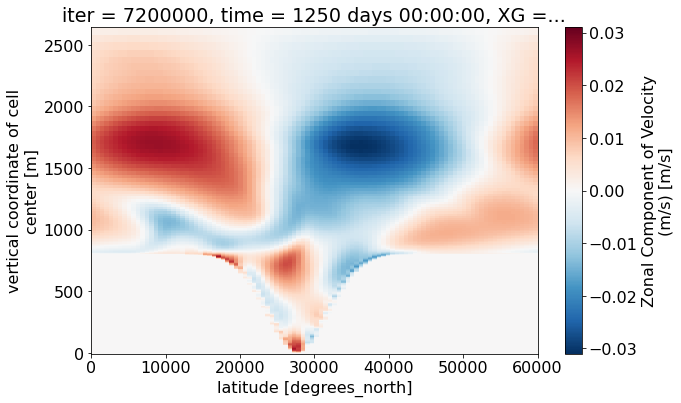

In [46]:
v["UVEL"].isel(XG=0, time=-1).plot()

In [ ]:
ds['Nsq'].mean(['XC']).isel(time=-1).plot(cmap=cmap, vmin=0., vmax=2e-6)

In [28]:
mx_mean_depth = (-ds['Depth'] + ds.attrs['H']).mean(dim='XC')
mx_min_depth = (-ds['Depth'] + ds.attrs['H']).min(dim='XC')

In [29]:
U = (ds['UVEL']*ds['drF']*ds['hFacW']).sum('Z')
Ubot = (ds['UVEL']*ds['drF']*ds['hFacW']).sel(Z=ds['Z'][::-1].sel(Z=slice(0, 800))[::-1]).sum('Z')
ds['Depthr'].load();

In [66]:
def format_yz_section(ax):
    ax.set_xlabel("cross-canyon distance [km]")
    ax.set_xticks(np.arange(0., 70e3, 10e3))
    ax.set_xticklabels(np.arange(0, 70, 10))
    ax.set_xlim([60e3, 0e3])
    ax.set_ylabel("height above mean-slope [m]")
    ax.set_title("")
    
def format_xz_section(ax):
    ax.set_xlabel("along-canyon distance [km]")
    xticks = np.arange(0, 500, 50)
    xticklabels = [str(x) if (i+1)%2 else '' for i, x in enumerate(xticks)]
    ax.set_xticks(xticks*1e3)
    ax.set_xticklabels(xticklabels)
    ax.set_xlim([0, 480e3])
    ax.set_ylabel("depth [m]")
    ax.set_title("")
    
def clean_long_plots(ax):
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title("")

    xticks = np.arange(0, 500, 20)
    #xticklabels = [str(x) if (i+1)%2 else '' for i, x in enumerate(xticks)]
    xticklabels = [str(x) for i, x in enumerate(xticks)]
    ax.set_xticks(xticks*1e3)
    ax.set_xticklabels(xticklabels)

    yticks = np.arange(0, 80, 20)
    yticklabels = [str(x) for i, x in enumerate(yticks)]
    ax.set_yticks(yticks*1e3)
    ax.set_yticklabels(yticklabels)

In [31]:
ds.attrs['H_actual'] = ds['Depth_actual'].max().values
ds = ds.assign_coords({'Zr_actual': ds.attrs['H_actual'] - ds['Zr']})
ds = ds.assign_coords({'Zr_U_actual': ds.attrs['H_actual'] - ds['Zr_U']})

In [32]:
Ubot.isel(time=0)

<xarray.DataArray (YC: 100, XG: 800)>
dask.array<getitem, shape=(100, 800), dtype=float64, chunksize=(100, 800), chunktype=numpy.ndarray>
Coordinates:
    iter     int64 dask.array<chunksize=(), meta=np.ndarray>
    time     timedelta64[ns] 1250 days
  * YC       (YC) >f8 300.0 900.0 1.5e+03 2.1e+03 ... 5.85e+04 5.91e+04 5.97e+04
  * XG       (XG) >f8 0.0 600.0 1.2e+03 ... 4.782e+05 4.788e+05 4.794e+05
    dyG      (YC, XG) >f8 dask.array<chunksize=(100, 800), meta=np.ndarray>
    dxC      (YC, XG) >f8 dask.array<chunksize=(100, 800), meta=np.ndarray>
    rAw      (YC, XG) >f8 dask.array<chunksize=(100, 800), meta=np.ndarray>

In [77]:
ds.time.size

500

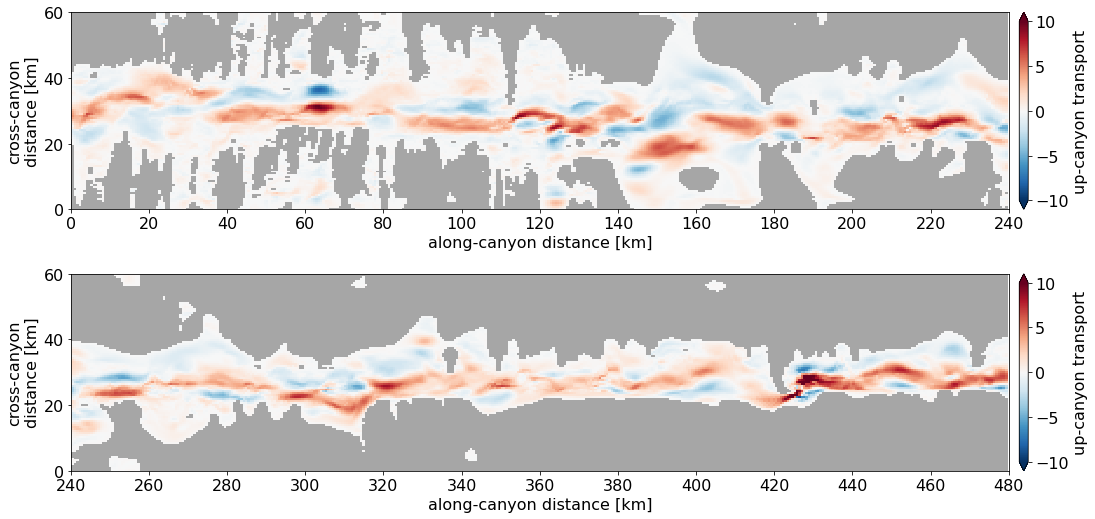

In [82]:
for t in range(ds.time.size//2):
    if t<1: continue
    fig = plt.figure(num=1, figsize=(16,7.5))
    fig.clf()
    gs = fig.add_gridspec(2, 1)

    ### XY
    ax1 = fig.add_subplot(gs[:1, :])
    PC = Ubot.isel(time=t, XG=slice(0,400)).where(Ubot.isel(time=t, XG=slice(0,400))!=0.).plot(vmin=-10, vmax=10, cmap=div_cmap, cbar_kwargs={
        'orientation': 'vertical',
        'label': r"up-canyon transport",
        'pad': 0.01,
        'fraction':0.1,
        'extend':'both'
    })

    Dep = ds['Depthr'].coarsen(dim={'XC': 2, 'YC':2}).mean()
    #Dep.plot.contour(levels=[2000], colors=[(0.15, 0.15, 0.15)])
    clean_long_plots(ax1)
    ax1.set_ylabel("cross-canyon\ndistance [km]")
    ax1.set_xlabel("along-canyon distance [km]");
    ax1.set_xlim(0, 240e3)

    ax2 = fig.add_subplot(gs[1:2, :])
    PC = Ubot.isel(time=t, XG=slice(400,800)).where(Ubot.isel(time=t, XG=slice(400,800))!=0.).plot(vmin=-10, vmax=10, cmap=div_cmap, cbar_kwargs={
        'orientation': 'vertical',
        'label': r"up-canyon transport",
        'pad': 0.01,
        'fraction':0.1,
        'extend':'both'
    })

    Dep = ds['Depthr'].coarsen(dim={'XC': 2, 'YC':2}).mean()
    #Dep.plot.contour(levels=[2000], colors=[(0.15, 0.15, 0.15)])
    clean_long_plots(ax2)
    ax2.set_ylabel("cross-canyon\ndistance [km]")
    ax2.set_xlabel("along-canyon distance [km]");
    ax2.set_xlim(240e3, 480e3)

    plt.tight_layout()
    plt.savefig(f"../../figures/BBTRE/movies/upslope_transport_{str(t).zfill(4)}.png", dpi=100., bbox_inches="tight")

### Relative vorticity

In [107]:
k_lev = [32, 55, 73, 100]
snap = open_mdsdataset(data_dir, ignore_unknown_vars=True, levels=k_lev, prefix=["levelDiag"], delta_t=delta_t, read_grid=False)
snap = snap.rename_dims({
    "i": "XC", "i_g": "XG",
    "j": "YC", "j_g": "YG",
    "k": "Z", "k_u": "Zu", "k_l": "Zl", "k_p1": "Zp1"
})

In [108]:
snap = snap.assign_coords(ds.isel(Z=k_lev, Zp1=np.append(k_lev, k_lev[-1]+1), Zu=k_lev, Zl=k_lev, time=0).drop("time").coords)

In [115]:
ζ = grid.interp(grid.interp((-grid.diff(snap.UVEL * snap.dxC, 'Y', boundary='extend')
     +grid.diff(snap.VVEL * snap.dyC, 'X', boundary='extend'))/snap.rAz,
'X'), 'Y')
ζ.name = 'relative vorticity'
ζ = ζ.where(snap.hFacC != 0.)

In [ ]:
for t in range(snap.time.size//5):
    if t<2: continue
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=True, figsize=(17,9), num=1)

    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.xlabel("along-canyon distance [km]")
    plt.ylabel("cross-canyon distance [km]")

    labels = ["a)", "b)", "c)", "d)"]
    for i in range(4):
        ax = axes[i]
        PC = (ζ/f).isel(time=t, Z=i).plot(ax=ax, cmap=div_cmap, vmin=-0.5, vmax=0.5)
        PC.colorbar.remove()
        clean_long_plots(ax)
        hab = np.int(snap['Z'].isel(Z=i).values)
        ax.set_title(
            label=f"{labels[i]} {hab} m above mean slope", loc='left',
            y=0.78, x=0.008, fontsize=13, color='k',
            bbox=dict(boxstyle="round",
                ec="k",
                fc="w",
            )
        )
        if i==0:
            ax.grid(True, alpha=0.3)
        if i==3:
            ax.annotate(fr"$t=${np.float64(snap.time[t]-snap.time[0])/(86400e9)} days", (0.825, 0.06), xycoords="axes fraction")

    fig.subplots_adjust(right=0.90)
    cbar_ax = fig.add_axes([0.915, 0.15, 0.015, 0.7])
    fig.colorbar(PC, cax=cbar_ax, ticks=[-0.5, -0.25, 0, 0.25, 0.5], label=r"relative vorticity $\zeta / f$")

    plt.savefig(f"../../figures/BBTRE/movies/vorticity_field_{str(t).zfill(4)}.png", dpi=150., bbox_inches='tight')

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0, 0.5, 'evelation [m]')

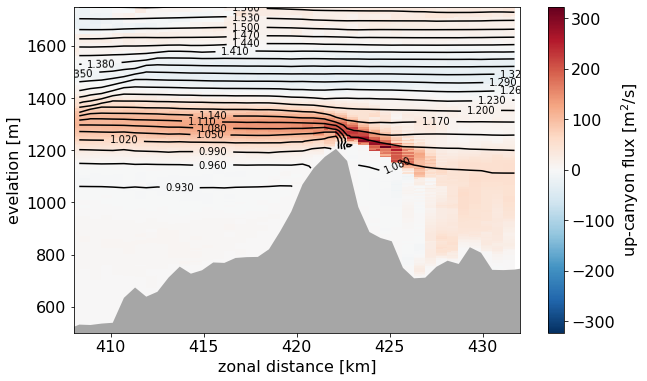

In [90]:
PC = (ds['UVEL']*dx).where(ds['UVEL']!=0.).isel(XG=slice(680, 720)).sum(dim='YC', skipna=True).plot(x='Xr_U', y='Zr_U')
PC.colorbar.set_label(r"up-canyon flux [m$^{2}$/s]")
CS = ds['THETA_BG'].isel(XC=slice(680, 720)).mean("YC", skipna=True).plot.contour(colors="k", levels=np.arange(0., 3., 0.03), x="Xr", y="Zr")
plt.clabel(CS, inline=1, fontsize=10)

plt.fill_between(ds['XC'], thalweg_dep*0., thalweg_dep, facecolor=nancol)
plt.xlim(ds['XG'].isel(XG=680), ds['XG'].isel(XG=720))
plt.ylim([500, 1750])
xticks = np.arange(410, 435, 5)
plt.xticks(xticks*1e3, xticks)
plt.xlabel("zonal distance [km]")
plt.ylabel("evelation [m]")

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


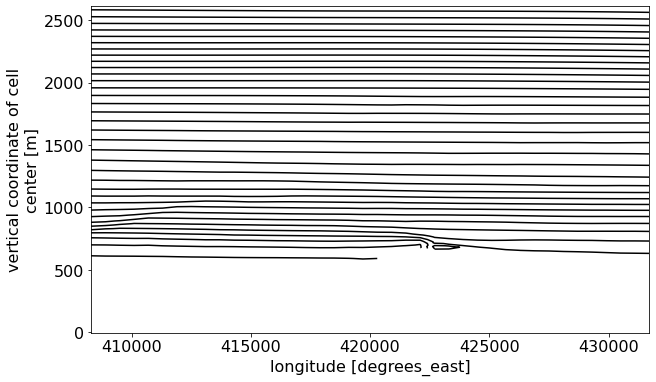

In [76]:
ds['THETA_BG'].isel(XC=slice(680, 720)).mean("YC", skipna=True).plot.contour(colors="k", levels=np.arange(0., 3., 0.05))

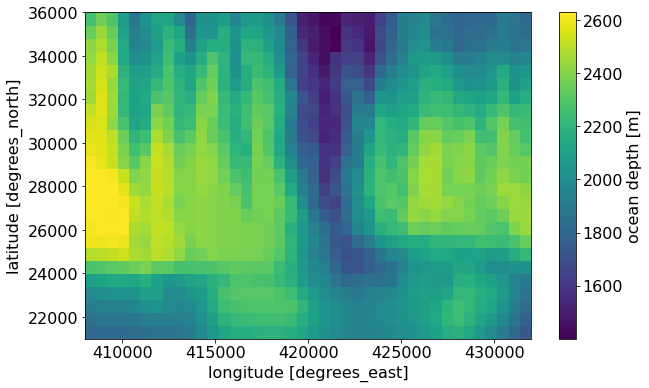

In [41]:
ds['Depth'].isel(XC=slice(680, 720), YC=slice(35, )).plot()